# User-Based Collaborative Filtering with MovieLens Dataset

# Importing Packages

In [2]:
import pandas as pd 
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Data Preperation

## Loading the MovieLens dataset

In [5]:
movies_url = "https://raw.githubusercontent.com/sidooms/MovieTweetings/master/latest/movies.dat"
ratings_url = "https://raw.githubusercontent.com/sidooms/MovieTweetings/master/latest/ratings.dat"

### Read the data

In [6]:
movies = pd.read_csv(movies_url, sep="::", engine ='python',names = ["MovieID","Title","Genres"])
ratings = pd.read_csv(ratings_url, sep ="::", engine ='python', names=["UserID", "MovieID", "Rating","Timestamp"])

In [8]:
movies

,MovieID,Title,Genres
0,8,Edison Kinetoscopic Record of a Sneeze (1894),Documentary|Short
1,10,La sortie des usines Lumière (1895),Documentary|Short
2,12,The Arrival of a Train (1896),Documentary|Short
3,25,The Oxford and Cambridge University Boat Race ...,NaN
4,91,Le manoir du diable (1896),Short|Horror
...,...,...,...
38013,15711402,Les rois de l&x27;arnaque (2021),Crime|Documentary
38014,15831978,Cash (2021),NaN
38015,15839820,Sompoy (2021),Comedy|Romance
38016,15842076,The Making of &x27;Rocky vs. Drago&x27; (2021),Documentary


In [10]:
ratings

,UserID,MovieID,Rating,Timestamp
0,1,114508,8,1381006850
1,2,499549,9,1376753198
2,2,1305591,8,1376742507
3,2,1428538,1,1371307089
4,3,75314,1,1595468524
...,...,...,...,...
921393,71705,9893250,10,1613857551
921394,71705,9898858,3,1585958452
921395,71706,172495,10,1587107015
921396,71706,414387,10,1587107852


### Merge Movies and ratings

In [19]:
data = pd.merge(ratings, movies, on="MovieID")
print(f"Dataset Loaded. First few rows: \n{data.head()}")

Dataset Loaded. First few rows: 
   UserID  MovieID  Rating   Timestamp           Title  \
0       1   114508       8  1381006850  Species (1995)   
1    1400   114508       7  1394296627  Species (1995)   
2    1431   114508       8  1371699243  Species (1995)   
3    9087   114508       7  1487513637  Species (1995)   
4    9105   114508       7  1462218295  Species (1995)   

                          Genres  
0  Action|Horror|Sci-Fi|Thriller  
1  Action|Horror|Sci-Fi|Thriller  
2  Action|Horror|Sci-Fi|Thriller  
3  Action|Horror|Sci-Fi|Thriller  
4  Action|Horror|Sci-Fi|Thriller  


###  Limit the dataset size to avoid overflow

In [20]:
# Filter for a subset of users and movies with sufficient ratings
filtered_users = data["UserID"].value_counts().head(500).index  # Top 500 users with most ratings
filtered_movies = data["MovieID"].value_counts().head(500).index  # Top 500 movies with most ratings

filtered_data = data[(data["UserID"].isin(filtered_users)) & (data["MovieID"].isin(filtered_movies))]

## Creating a user-item matrix

In [23]:
user_item_matrix = filtered_data.pivot_table(index="UserID", columns="Title", values="Rating")
user_item_matrix = user_item_matrix.fillna(0)  # Fill missing ratings with 0

print("User-Item Matrix created successfully.")
print(user_item_matrix.head())

User-Item Matrix created successfully.
Title   10 Cloverfield Lane (2016)  12 Angry Men (1957)  \
UserID                                                    
66                             0.0                  0.0   
111                            7.0                  0.0   
123                            0.0                  0.0   
280                            5.0                  0.0   
741                            0.0                  0.0   

Title   12 Years a Slave (2013)  1917 (2019)  2 Guns (2013)  \
UserID                                                        
66                          8.0          0.0            0.0   
111                         0.0          0.0            0.0   
123                         0.0          0.0            7.0   
280                         8.0          0.0            7.0   
741                         8.0          0.0            0.0   

Title   22 Jump Street (2014)  3 Days to Kill (2014)  \
UserID                                           

## Calculating the cosine similarity between users

In [43]:
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index =user_item_matrix.index, columns =user_item_matrix.index )
print(user_similarity)

[[1.         0.35736506 0.38401748 ... 0.24149958 0.42434704 0.33496806]
 [0.35736506 1.         0.2916209  ... 0.31186846 0.22295866 0.25134454]
 [0.38401748 0.2916209  1.         ... 0.22739353 0.49925266 0.35773429]
 ...
 [0.24149958 0.31186846 0.22739353 ... 1.         0.20579032 0.39882206]
 [0.42434704 0.22295866 0.49925266 ... 0.20579032 1.         0.46443847]
 [0.33496806 0.25134454 0.35773429 ... 0.39882206 0.46443847 1.        ]]


# Recommendation Function

In [28]:
def recommend_movies(user_id, user_item_matrix, user_similarity_df, num_recommendations=5):
    user_ratings = user_item_matrix.loc[user_id]
    similar_users = user_similarity_df[user_id].sort_values(ascending =False).iloc[1:] # Exclude self
    
    #Weighted average of ratings from similar users
    weighted_ratings =np.dot(similar_users.values, user_item_matrix.loc[similar_users.index])
    normalization = np.array([np.abs(similar_users).sum()]*user_item_matrix.shape[1])
    predicted_ratings = weighted_ratings / normalization
    
    # Recommend movies the user has not rate yet
    recommendations = pd.Series(predicted_ratings, index = user_item_matrix.columns)
    recommendations = recommendations[user_ratings ==0].sort_values(ascending =False).head(num_recommendations)
    
    return recommendations

## Example usage : Recommend movies for a specific user

In [42]:
user_id = filtered_users[2]
recommended_movies = recommend_movies(user_id, user_item_matrix, user_similarity_df, num_recommendations=5)

In [38]:
print(recommended_movies)

Title
The Imitation Game (2014)    4.051574
Blade Runner 2049 (2017)     2.770281
The Conjuring (2013)         2.651867
Non-Stop (2014)              2.556215
Don't Breathe (2016)         2.462559
dtype: float64


### Visualize user Similarity

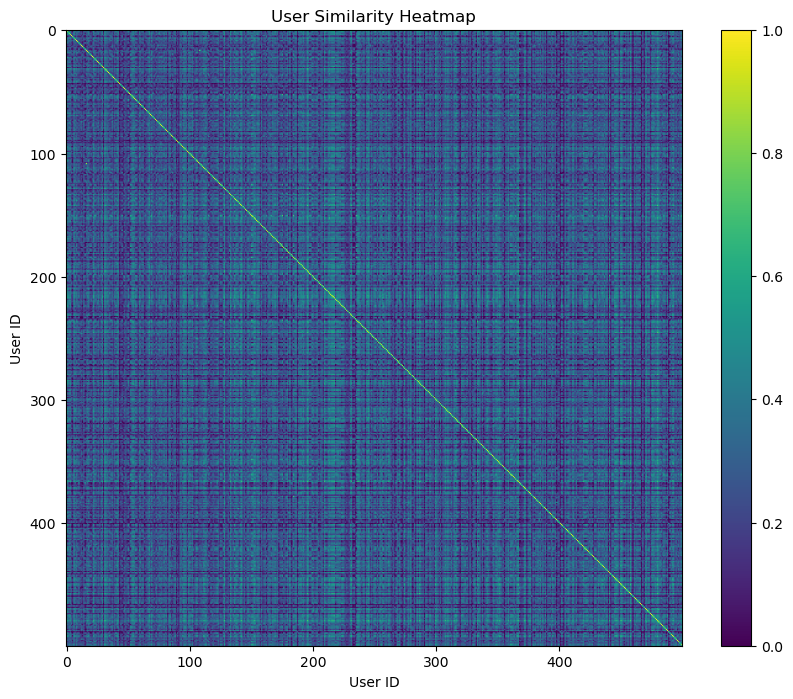

In [44]:
plt.figure(figsize=(10,8))
plt.imshow(user_similarity,cmap="viridis")
plt.colorbar()
plt.title("User Similarity Heatmap")
plt.xlabel("User ID")
plt.ylabel("User ID")
plt.show()

# Data Examination

In [46]:
print(data.describe())

              UserID       MovieID         Rating     Timestamp
count  923235.000000  9.232350e+05  923235.000000  9.232350e+05
mean    36099.626852  2.280938e+06       7.313674  1.465254e+09
std     20815.742990  2.194079e+06       1.852255  7.427165e+07
min         1.000000  8.000000e+00       0.000000  1.362062e+09
25%     18278.000000  7.654290e+05       6.000000  1.397901e+09
50%     36033.000000  1.729226e+06       8.000000  1.453557e+09
75%     53822.000000  2.980516e+06       9.000000  1.521497e+09
max     71707.000000  1.605874e+07      10.000000  1.637732e+09


In [54]:
# Top-rated movies 
top_movies = data.groupby("Title")["Rating"].mean().sort_values(ascending=False).head(10)
print("Top-rated Movies: \n",top_movies)

Top-rated Movies: 
 Title
Flashback (2011)                                 10.0
Divorce Corp (2014)                              10.0
World 1-1 (2015)                                 10.0
Raging Balls of Steel Justice (2013)             10.0
World Peace (2013)                               10.0
If I Can&x27;t Have Love, I Want Power (2021)    10.0
If I Die Tomorrow (2013)                         10.0
If I Were King (1938)                            10.0
If It's Tuesday, This Must Be Belgium (1969)     10.0
Dixon (2011)                                     10.0
Name: Rating, dtype: float64


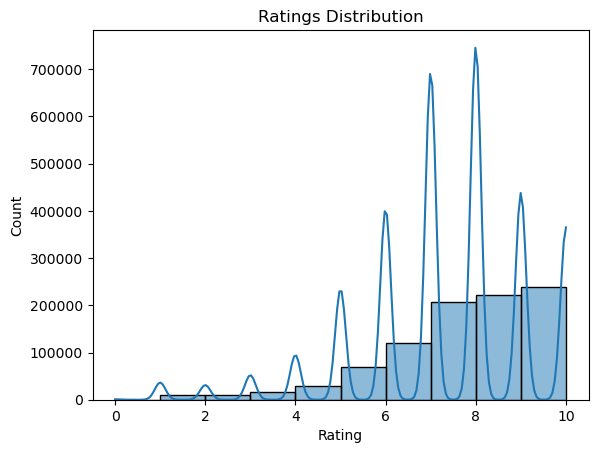

In [60]:
# Distribution of Ratings
import seaborn as sns

sns.histplot(data["Rating"],bins=10,kde=True)
plt.title("Ratings Distribution")
plt.show()

In [69]:
# Filter for a subset of users and movies with sufficient ratings
filtered_users = data["UserID"].value_counts().head(1000).index  # Top 500 users with most ratings
filtered_movies = data["MovieID"].value_counts().head(1000).index  # Top 500 movies with most ratings

filtered_data = data[(data["UserID"].isin(filtered_users)) & (data["MovieID"].isin(filtered_movies))]

# User-Item Interaction Matrix
user_item_matrix = filtered_data.pivot_table(index="UserID", columns="Title", values="Rating", fill_value=0)
print(user_item_matrix.head())

Title   '71 (2014)  10 Cloverfield Lane (2016)  12 Angry Men (1957)  \
UserID                                                                
66               0                           0                    0   
111              0                           7                    0   
123              0                           0                    0   
215              0                           0                    0   
251              0                           0                    0   

Title   12 Years a Slave (2013)  127 Hours (2010)  13 Hours (2016)  \
UserID                                                               
66                            8                 0                0   
111                           0                 0                8   
123                           0                 0                0   
215                           7                 0                0   
251                           0                 0                0   

Title   191

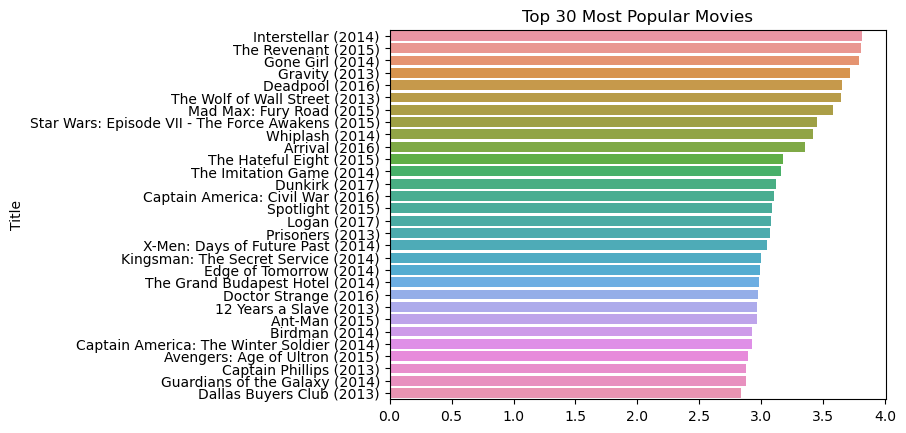

In [71]:
# Heatmap of Popular Movies
popular_movies = user_item_matrix.mean(axis=0).sort_values(ascending=False).head(30)
sns.barplot(x=popular_movies.values, y=popular_movies.index)
plt.title("Top 30 Most Popular Movies")
plt.show()